Installation von fastai in colab....

In [ ]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 17.1MB/s 
     |████████████████████████████████| 194kB 55.9MB/s 
     |████████████████████████████████| 51kB 8.7MB/s 
     |████████████████████████████████| 1.2MB 50.9MB/s 
     |████████████████████████████████| 61kB 7.6MB/s 
     |████████████████████████████████| 51kB 8.6MB/s 
Mounted at /content/gdrive


Installation der erforderlichen Bibliotheken für DICOM Bilder

In [ ]:
!pip install pydicom kornia opencv-python scikit-image nbdev

     |████████████████████████████████| 1.9MB 17.8MB/s 
     |████████████████████████████████| 225kB 50.8MB/s 


Notwendige Imports....

In [ ]:
from fastai.basics import *
from fastai.callback.all import *
from fastai.vision.all import *
from fastai.data.transforms import *
from fastai.medical.imaging import *

import pydicom,kornia,skimage

from matplotlib.colors import ListedColormap, LinearSegmentedColormap
try:
    import cv2
    cv2.setNumThreads(0)
except: pass

import seaborn as sns

import pandas as pd

# Analyse von Röntgen Bildern mithilfe von fastai

## Das DICOM Bildformat

DICOM steht für **D**igital **I**mageing and **CO**mmunication in **M**edicine) und stellt den _defacto_ bzw. Industriestandard für die Speicherung und Übertragung von Bilddaten in der Medizin dar (allen voran natürlich Röntgen, MRT, CT Bilder).

Mithilfe von DICOM können derartige Aufnahmen unabhängig vom Gerätetyp und Hersteller übertragen werden. Parallel mit den eigentlichen Bilddaten können mittels DICOM auch noch weitere Daten, wie Patientendaten mit den Bildern gemeinsam übertragen werden.



16-Bit DICOM Bilder haben typischerweise einen Wertebereich von -32768 bis 32768, während 8-Bit Graustufen-Bilder typischerweise Pixelwerte von 0-255 aufweisen.

Die Wertebereiche in DICOM Bildern korrelieren in der Regel mit der Hounsfield Skala, die eine quantitative Skala zur Beschreibung der Röntgendichte darstellt.

## DICOM Datensets

### Fastai SIIM Small Datenset
250 Röntgenfotos inkl. Lables. Wird direkt über die URLs in der Fastai Library angesprochen. Beinhaltet jedoch kein `RescaleIntercept` und `RescaleSlope`. Die Bereiche für die Pixel sind mit einem Wertebereich von 0 bis 255 beschränkt.

![](https://docs.fast.ai/images/siim_folder_structure.jpeg)

Bildquelle: https://docs.fast.ai/images/siim_folder_structure.jpeg

In [ ]:
pneumothorax_source = untar_data(URLs.SIIM_SMALL)

In [ ]:
(pneumothorax_source/'train').ls()

(#2) [Path('/root/.fastai/data/siim_small/train/No Pneumothorax'),Path('/root/.fastai/data/siim_small/train/Pneumothorax')]

### Das Thyroid Datenset von Kaggle

Das [Thyroid Datenset von Kaggle](https://opencas.webarchiv.kit.edu/?q=node/29) beinhaltet Ultraschallbilder in geringer Auflösung (253x253 Pixel). Jedes der beinhalteten DICOM Elemente besteht aus mehreren Frames (durchschnittlich 1000). Die Segmentierung kann zur Berechnung des Volumens benutzt werden.

Auf jedem Bild wurde der Bereich der Schilddrüse von Experten segmentiert.

![](https://opencas.webarchiv.kit.edu/data/image003.png)

In [ ]:
!wget https://opencas.webarchiv.kit.edu/data/thyroid.zip
!unzip thyroid.zip -d thyroid

--2021-03-03 07:50:17--  https://opencas.webarchiv.kit.edu/data/thyroid.zip
Resolving opencas.webarchiv.kit.edu (opencas.webarchiv.kit.edu)... 129.13.41.190, 2a00:1398:9:fd10::810d:29be
Connecting to opencas.webarchiv.kit.edu (opencas.webarchiv.kit.edu)|129.13.41.190|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 432315445 (412M) [application/zip]
Saving to: ‘thyroid.zip.1’

thyroid.zip.1       100%[===================>] 412.29M  26.2MB/s    in 23s     

2021-03-03 07:50:41 (17.9 MB/s) - ‘thyroid.zip.1’ saved [432315445/432315445]

Archive:  thyroid.zip
replace thyroid/data/D01.dcm? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
tsource = Path('thyroid')
titems = get_dicom_files(tsource)

In [ ]:
matplotlib.rcParams['image.cmap'] = 'bone'

1134 frames per file


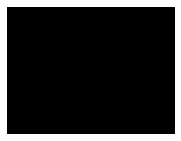

In [ ]:
patient_thyr = titems[7].dcmread()
patient_thyr.show()

Hier erhalten wir einen `TypeError`, weil die `show` Funktion nicht darauf ausgelegt ist, Dateien mit meheren Frames anzuzeigen.

Wir können die `show` Funktion jedoch entsprechend anpassen, sodass diese überprüft, ob mehrere Frames vorhanden sind und diese korrekt anzeigt.

Die `show_images` Funktion unterstützt in der Standardversion auch keine `cmaps` (colormaps), weshalb wir diese Funktion auch etwas anpassen wollen.

In [ ]:
@delegates(subplots)
def show_images(ims, nrows=1, ncols=None, titles=None, cmap=None, **kwargs):
    "Show all images `ims` as subplots with `rows` using `titles`"
    if ncols is None: ncols = int(math.ceil(len(ims)/nrows))
    if titles is None: titles = [None]*len(ims)
    axs = subplots(nrows, ncols, **kwargs)[1].flat
    for im,t,ax in zip(ims, titles, axs): show_image(im, ax=ax, title=t, cmap=cmap)

In [ ]:
#updating to handle multiple frames
@patch
@delegates(show_image, show_images)
def show(self:DcmDataset, frames=1, scale=True, cmap=plt.cm.bone, min_px=-1100, max_px=None, **kwargs):
    px = (self.windowed(*scale) if isinstance(scale,tuple)
          else self.hist_scaled(min_px=min_px,max_px=max_px,brks=scale) if isinstance(scale,(ndarray,Tensor))
          else self.hist_scaled(min_px=min_px,max_px=max_px) if scale
          else self.scaled_px)
    if px.ndim > 2: 
        gh=[]
        p = px.shape; print(f'{p[0]} frames per file')
        for i in range(frames): u = px[i]; gh.append(u)
        show_images(gh, cmap=cmap, **kwargs)    
    else: 
        print('1 frame per file')
        show_image(px, cmap=cmap, **kwargs)

1134 frames per file


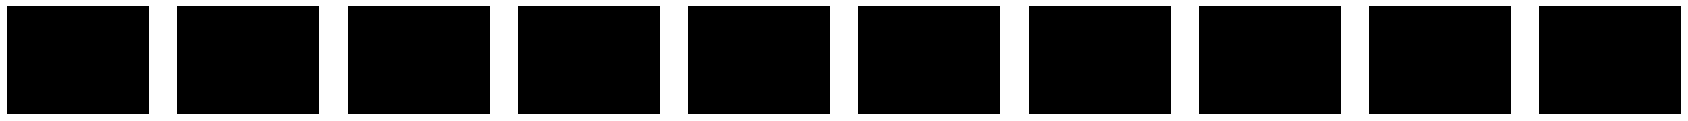

In [ ]:
patient_thyr.show(10)

1134 frames per file


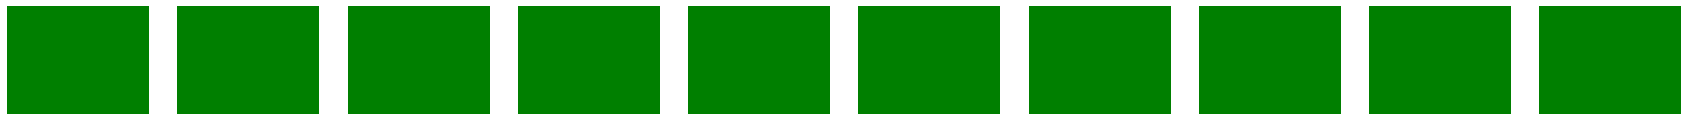

In [ ]:
patient_thyr.show(10, cmap=plt.cm.ocean)

1134 frames per file


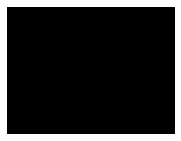

In [ ]:
patient_thyr.show()

### DAS CT-Medical Images Datenset von Kaggle

In [ ]:
!wget https://ct-medical-data.s3.eu-de.cloud-object-storage.appdomain.cloud/archive.zip
!unzip archive.zip -d ct-images

--2021-03-03 13:20:31--  https://ct-medical-data.s3.eu-de.cloud-object-storage.appdomain.cloud/archive.zip
Resolving ct-medical-data.s3.eu-de.cloud-object-storage.appdomain.cloud (ct-medical-data.s3.eu-de.cloud-object-storage.appdomain.cloud)... 158.177.118.97
Connecting to ct-medical-data.s3.eu-de.cloud-object-storage.appdomain.cloud (ct-medical-data.s3.eu-de.cloud-object-storage.appdomain.cloud)|158.177.118.97|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 261989898 (250M) [application/zip]
Saving to: ‘archive.zip’

archive.zip         100%[===================>] 249.85M  20.9MB/s    in 13s     

2021-03-03 13:20:45 (19.1 MB/s) - ‘archive.zip’ saved [261989898/261989898]

Archive:  archive.zip
  inflating: ct-images/dicom_dir/ID_0000_AGE_0060_CONTRAST_1_CT.dcm  
  inflating: ct-images/dicom_dir/ID_0001_AGE_0069_CONTRAST_1_CT.dcm  
  inflating: ct-images/dicom_dir/ID_0002_AGE_0074_CONTRAST_1_CT.dcm  
  inflating: ct-images/dicom_dir/ID_0003_AGE_0075_CONTRAST_

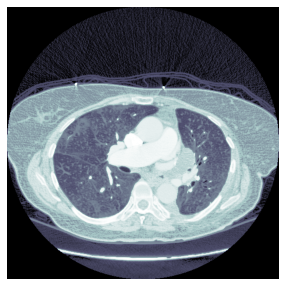

In [ ]:
ct_images = Path('ct-images')
citems = get_dicom_files(ct_images)
patient2 = citems[0].dcmread()
patient2.show()

#### Gewebedichte anzeigen

Das SIIM Datenset weist hinsichtlich der Möglichkeiten, die DICOM Bilder bieten einige Schwächen auf, aufgrund derer nicht das volle Potential, das der DICOM Standard liefert, ausgeschöpft werden kann.

Es fehlen etwa die Attribute `RescaleIntercept` und `RescaleSlope`. Die Werteverteilung der einzelnen Pixelwerte ist auf 8 Bit (0 bis 255) limitiert.

Wenn wir das CT-Bilder Datenset von Kaggle verwenden, können wir diese Attribute nutzen. Das `fastai.medical.imaging` Module bietet einige Funktionen, die wir nun genauer betrachten werden.

In [ ]:
tensor_dicom =  TensorDicom(patient2.pixel_array)

print(f'RescaleIntercept: {patient2.RescaleIntercept:1f}')
print(f'RescaleSlope: {patient2.RescaleSlope:1f}')
print(f'Max pixel: {tensor_dicom.max()}')
print(f'Min pixel: {tensor_dicom.min()}')
print(f'\nShape: {tensor_dicom.shape}')

RescaleIntercept: -1024.000000
RescaleSlope: 1.000000
Max pixel: 4095
Min pixel: -2000

Shape: torch.Size([512, 512])


Histgramm der Verteilung der Pixelwerte

(array([5.57720e+04, 0.00000e+00, 0.00000e+00, 1.10212e+05, 6.22950e+04, 3.21100e+04, 1.71000e+03, 2.90000e+01, 3.00000e+00, 1.30000e+01]),
 array([-2000. , -1390.5,  -781. ,  -171.5,   438. ,  1047.5,  1657. ,  2266.5,  2876. ,  3485.5,  4095. ]),
 <a list of 10 Patch objects>)

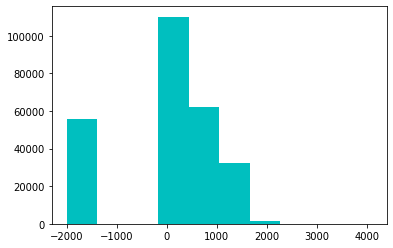

In [ ]:
plt.hist(tensor_dicom.flatten(), color='c')

Das Histogramm zeigt eine bimodale Verteilung mit den größten Häufigkeiten rund um die Bereiche von 0 bis 100 und 750 bis 1100 Pixel.

In diesem DICOM CT-Scan weisen `RescaleIntercept` den Wert `-1024` und `RescaleSlope` den Wert `1` auf. Diese beiden Pixelwerte erlauben, die Bildwerte in die `Hounsfield Skala` zu transferieren.

Eine Vielzahl an CT-Scans liegen den Bereichen zwischen -1000 HU und +1000 HU. Wasser weist 0 HU und Luft -1000 HU auf. Je dichter das Material, desto höher ist auch der Wert auf der Hounsfield Skala. Metalle bewegen sich in der Regeln in einem Bereich ab +2000 HU.

Aus diesem Grund ist der Wertebereich zwischen -1000 und +1000 HU im medizinischen Umfeld.

Die Pixelwerte aus dem obigen CT-Scan Bild weisen diese Dichtewerte nicht von sich aus korrekt auf. Die meisten Pixelwerte liegen im Bereich von 0 bis 100, was etwa dem Bereich von Wasser entspricht. Doch zeigen die CT-Scans aus diesem Datenset hauptsächlich Aufnahmen von Lunge, die mit Luft gefüllt sind. (Wir erinnern uns, Luft hat etwa -1000 HU).

Nun benötigen wir `RescaleIntercept` und `RescaleSlope`, um diese Pixelwerte korrekt umzurechnen.

Mithilfe der Funktion `scaled_px` aus dem fastai-Framework können wir die Pixelwerte unter Berücksichtigung von `RescaleIntercept` und `RescaleSlope` nun sehr bequem umrechnen.

`rescaled pixel = pixel * RescaleSlope + RescaleIntercept`

(array([5.57720e+04, 0.00000e+00, 0.00000e+00, 1.10212e+05, 6.22950e+04, 3.21100e+04, 1.71000e+03, 2.90000e+01, 3.00000e+00, 1.30000e+01]),
 array([-3024. , -2414.5, -1805. , -1195.5,  -586. ,    23.5,   633. ,  1242.5,  1852. ,  2461.5,  3071. ], dtype=float32),
 <a list of 10 Patch objects>)

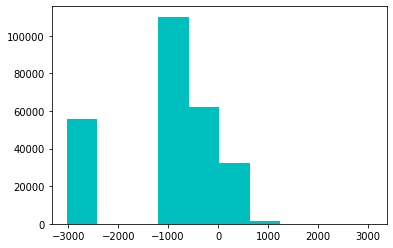

In [ ]:
#convert into tensor taking RescaleIntercept and RescaleSlope into consideration
tensor_dicom_scaled = patient2.scaled_px
plt.hist(tensor_dicom_scaled.flatten(), color='c')

Nachdem wir nun das Rescaling durchgeführt haben, ist unser maximaler Pixelwert bei 894 und der minimale Pixelwert bei -1024. Nun können wir auch aus den Bereichen der Pixelwerte korrekt ablesen, auf welchen Gewebetyp sich der Bereich bezieht, indem wir die Skalenfenster der Hounsfield Skala heranziehen.

Betrachten wir nun alle Bereiche mit Werte über 300 HE, welche typischerweise Knochenstrukturen darstellen.

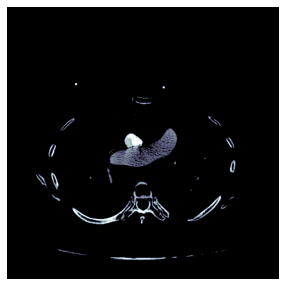

In [ ]:
patient2.show(max_px=894, min_px=300, figsize=(5,5))

Mit einem Bereich von `-250` bis `-600` können wir gut die äußeren Grenzen der Aufnahme verdeutlichen.

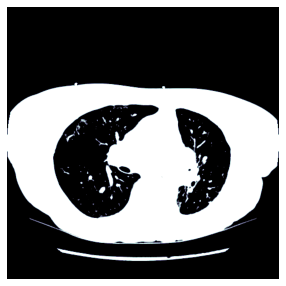

In [ ]:
patient2.show(max_px=-250, min_px=-600, figsize=(5,5))

Mit folgendem Bereich auf der Hounsfield Skala können wir in die Bronchien "hineinzoomen" - bzw. die Bronchien darstellen.

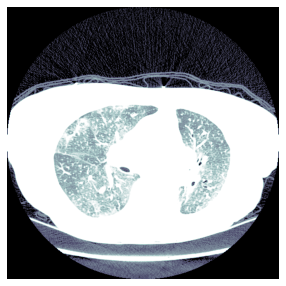

In [ ]:
patient2.show(max_px=-600, min_px=-1000, figsize=(5,5))

Die Standardwerte der Funktion liefern ein gutes Spektrum zur Darstellung der CT-Aufnahmen:

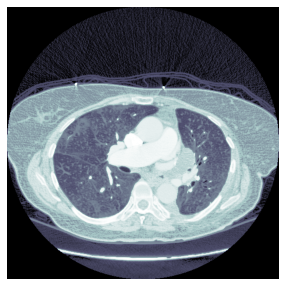

In [ ]:
patient2.show(max_px=None, min_px=-1100, figsize=(5,5))

Die Anpassung der Bereiche auf der Hounsfield Skala, die angezeigt werden sollen, dienen hauptsächlich dem menschlichen Betrachter, um bestimmte Elemente auf dem CT-Scan besser erkennen zu können. Denn während ein typisches Computerdisplay 255 verschiedene Graustufen darstellen kann, kann das menschliche Auge nur etwa 17 verschiedene Abstufungen erkennen.

Mit einem Wertebereich für die Pixel von -1000 bis +1000 liefern DICOM Bilder eine sehr hohe Informationsdichte, um spezifische Bereich für das menschliche Auge besser erkennbar zu machen, hat sich das Konzept der Fensterbereiche für die Pixel etabliert.

###### Aufteilung in Bins

Das Konzept des Pixelbereichsfenster ist für menschliche Anwender interessant. Ein neuronales Netz lernt besser auf Basis von Daten, die normalverteilt sind.

(array([5.57720e+04, 0.00000e+00, 0.00000e+00, 1.10212e+05, 6.22950e+04, 3.21100e+04, 1.71000e+03, 2.90000e+01, 3.00000e+00, 1.30000e+01]),
 array([-3024. , -2414.5, -1805. , -1195.5,  -586. ,    23.5,   633. ,  1242.5,  1852. ,  2461.5,  3071. ], dtype=float32),
 <a list of 10 Patch objects>)

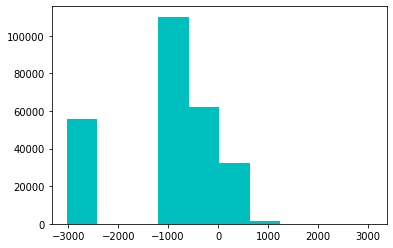

In [ ]:
plt.hist(tensor_dicom_scaled.flatten(), color='c')

Die Pixelwerte aus unserem Datenset weise eine bimodale Verteilung auf.

Mithilfe der Funktion `freqhist_hist` aus dem fastai Framework können wir die Bereiche der Pixelverteilung in einzelne Gruppen aufteilen - abhängig von der vorgegebenen Anzahl an Bins (`n_bin`). Jede der erstellten Gruppen beinhaltet dann etwa die gleiche Anzahl an Pixelwerten.

Teilen wir nun alle Pixelwerte in zwei Gruppen auf:

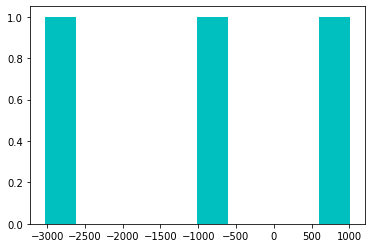

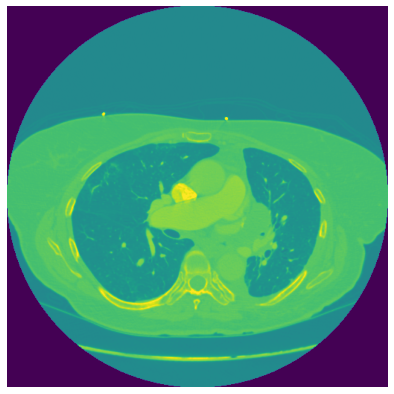

In [ ]:
ten_freq = tensor_dicom_scaled.freqhist_bins(n_bins=1)
fh = patient2.hist_scaled(ten_freq)
plt.hist(ten_freq.flatten(), color='c'); show_image(fh, figsize=(7,7))


Wir sehen nun eine etwa Gleichverteilung der Pixel in die einzelnen bins. Für unser neuronales Netz ist jedoch auch diese Aufteilung noch immer nicht ideal.

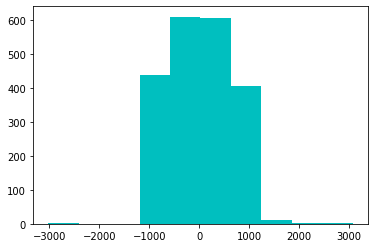

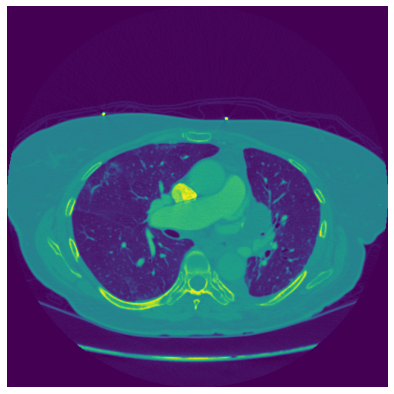

In [ ]:
ten_freq3 = tensor_dicom_scaled.freqhist_bins(n_bins=100000)
fh3 = patient2.hist_scaled(ten_freq3)
plt.hist(ten_freq3.flatten(), color='c'); show_image(fh3, figsize=(7,7))

## DICOM Bilder anzeigen

In [ ]:
items = get_dicom_files(pneumothorax_source, recurse=True, folders="train")

In [ ]:
len(items)

250

In [ ]:
trn,val = RandomSplitter()(items)

Pydicom ist ein Modul zur einfacheren Verarbeitung von DICOM Bildern mit Python. Das `fastai.medical.imaging` Modul verwendet intern die Methode `dcmread()` zur Anzeige von DICOM Bildern.

In [ ]:
patient = 7
xray_sample = items[patient].dcmread()

In [ ]:
# Header Informationen vom DICOM Bild anzeigen
xray_sample

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 202
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.12017.1517875236.916922
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.12017.1517875236.916922
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time      

In [ ]:
xray_sample.PixelData[:200]

b'\xfe\xff\x00\xe0\x00\x00\x00\x00\xfe\xff\x00\xe0B\xd2\x01\x00\xff\xd8\xff\xdb\x00C\x00\x03\x02\x02\x02\x02\x02\x03\x02\x02\x02\x03\x03\x03\x03\x04\x06\x04\x04\x04\x04\x04\x08\x06\x06\x05\x06\t\x08\n\n\t\x08\t\t\n\x0c\x0f\x0c\n\x0b\x0e\x0b\t\t\r\x11\r\x0e\x0f\x10\x10\x11\x10\n\x0c\x12\x13\x12\x10\x13\x0f\x10\x10\x10\xff\xc0\x00\x0b\x08\x04\x00\x04\x00\x01\x01\x11\x00\xff\xc4\x00\x1d\x00\x00\x02\x03\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x04\x05\x02\x03\x06\x00\x01\x07\x08\t\xff\xc4\x00n\x10\x00\x01\x04\x01\x03\x02\x05\x01\x04\x05\x03\x0b\x0b\x0e\x05\x15\x01\x00\x02\x03\x11\x04\x12!1\x05A\x06\x13"Qaq\x07\x142\x81#B\x91\xa1\xb1\x08\x95\xd2\t\x15\x173RWr\xb3\xc1\xd1\xd3\x16$%Ebe\x92\x93'

In [ ]:
# mithilfe von PyDicom können wir Pixel Data in ein Numpy Array konvertieren
xray_sample.pixel_array, xray_sample.pixel_array.shape

(array([[ 1,  1,  1, ...,  1,  1,  1],
        [ 1,  1,  1, ...,  1,  1,  1],
        [ 1,  1,  1, ...,  1,  1,  1],
        ...,
        [22, 36, 36, ..., 33, 34, 22],
        [22, 35, 35, ..., 33, 34, 22],
        [ 8, 20, 20, ..., 18, 20,  8]], dtype=uint8), (1024, 1024))

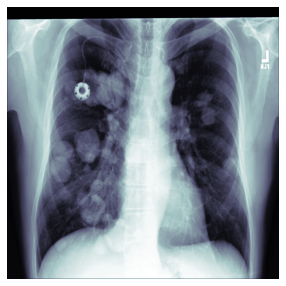

In [ ]:
# anzeigen des Bildes
xray_sample.show()

### Anpassen der `show`-Methode für DICOM Bilder

Anzeige der wesentlichen DICOM Attribute gemeinsam mit dem Bild.

In [ ]:
@patch
@delegates(show_image)
def show_dinfo(self:DcmDataset, scale=True, cmap=plt.cm.bone, min_px=-1100, max_px=None, **kwargs):
    """show function that prints patient attributes from DICOM head"""
    px = (self.windowed(*scale) if isinstance(scale,tuple)
          else self.hist_scaled(min_px=min_px,max_px=max_px,brks=scale) if isinstance(scale,(ndarray,Tensor))
          else self.hist_scaled(min_px=min_px,max_px=max_px) if scale
          else self.scaled_px)
    print(f'Patient Age: {self.PatientAge}')
    print(f'Patient Sex: {self.PatientSex}')
    print(f'Body Part Examined: {self.BodyPartExamined}')
    print(f'Rows: {self.Rows} Columns: {self.Columns}')
    show_image(px, cmap=cmap, **kwargs)

Patient Age: 61
Patient Sex: M
Body Part Examined: CHEST
Rows: 1024 Columns: 1024


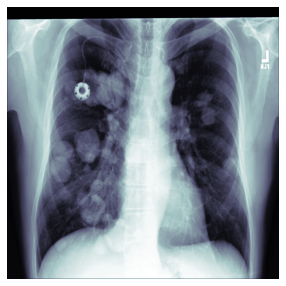

In [ ]:
xray_sample.show_dinfo()

### DICOM Bilder als DataFrame laden

In [ ]:
# DataFrame Objekt erzeugen
dicom_dataframe = pd.DataFrame.from_dicoms(items)
dicom_dataframe[:5]

,SpecificCharacterSet,SOPClassUID,SOPInstanceUID,StudyDate,StudyTime,AccessionNumber,Modality,ConversionType,ReferringPhysicianName,SeriesDescription,PatientName,PatientID,PatientBirthDate,PatientSex,PatientAge,BodyPartExamined,ViewPosition,StudyInstanceUID,SeriesInstanceUID,StudyID,SeriesNumber,InstanceNumber,PatientOrientation,SamplesPerPixel,PhotometricInterpretation,Rows,Columns,PixelSpacing,BitsAllocated,BitsStored,HighBit,PixelRepresentation,LossyImageCompression,LossyImageCompressionMethod,fname,MultiPixelSpacing,PixelSpacing1,img_min,img_max,img_mean,img_std,img_pct_window
0,ISO_IR 100,1.2.840.10008.5.1.4.1.1.7,1.2.276.0.7230010.3.1.4.8323329.5011.1517875185.953072,19010101,000000.00,,CR,WSD,,view: AP,"(a, d, c, 7, 8, d, a, 5, -, d, b, 5, d, -, 4, 1, e, 4, -, 8, d, 3, c, -, 6, 9, c, 3, 5, 6, f, a, f, 7, e, a)",adc78da5-db5d-41e4-8d3c-69c356faf7ea,,F,29,CHEST,AP,1.2.276.0.7230010.3.1.2.8323329.5011.1517875185.953071,1.2.276.0.7230010.3.1.3.8323329.5011.1517875185.953070,,1,1,,1,MONOCHROME2,1024,1024,0.168,8,8,7,0,01,ISO_10918_1,/root/.fastai/data/siim_small/train/No Pneumothorax/000206.dcm,1,0.168,0,255,149.318254,63.576097,0.126198
1,ISO_IR 100,1.2.840.10008.5.1.4.1.1.7,1.2.276.0.7230010.3.1.4.8323329.14060.1517875249.409180,19010101,000000.00,,CR,WSD,,view: AP,"(1, 7, 2, 0, a, 6, 0, b, -, 2, b, 0, 7, -, 4, 5, f, 3, -, 8, f, f, 5, -, d, 6, 2, 4, a, 0, e, 5, b, e, 0, 5)",1720a60b-2b07-45f3-8ff5-d624a0e5be05,,M,55,CHEST,AP,1.2.276.0.7230010.3.1.2.8323329.14060.1517875249.409179,1.2.276.0.7230010.3.1.3.8323329.14060.1517875249.409178,,1,1,,1,MONOCHROME2,1024,1024,0.139,8,8,7,0,01,ISO_10918_1,/root/.fastai/data/siim_small/train/No Pneumothorax/000225.dcm,1,0.139,0,255,126.826672,56.721515,0.156144
2,ISO_IR 100,1.2.840.10008.5.1.4.1.1.7,1.2.276.0.7230010.3.1.4.8323329.12954.1517875242.700587,19010101,000000.00,,CR,WSD,,view: AP,"(c, 6, 1, f, 7, 8, f, 8, -, 9, d, f, 9, -, 4, 3, 6, 0, -, a, 7, 3, 8, -, 2, 1, b, 3, 9, 9, 1, c, 2, c, c, c)",c61f78f8-9df9-4360-a738-21b3991c2ccc,,F,59,CHEST,AP,1.2.276.0.7230010.3.1.2.8323329.12954.1517875242.700586,1.2.276.0.7230010.3.1.3.8323329.12954.1517875242.700585,,1,1,,1,MONOCHROME2,1024,1024,0.139,8,8,7,0,01,ISO_10918_1,/root/.fastai/data/siim_small/train/No Pneumothorax/000244.dcm,1,0.139,0,255,124.715261,51.732013,0.145900
3,ISO_IR 100,1.2.840.10008.5.1.4.1.1.7,1.2.276.0.7230010.3.1.4.8323329.14484.1517875252.318328,19010101,000000.00,,CR,WSD,,view: AP,"(1, 0, 9, e, 0, d, a, 2, -, 0, 6, c, 6, -, 4, 4, 1, 9, -, 9, a, 0, a, -, 6, 3, 4, 2, b, 5, 0, b, 7, b, e, c)",109e0da2-06c6-4419-9a0a-6342b50b7bec,,M,58,CHEST,AP,1.2.276.0.7230010.3.1.2.8323329.14484.1517875252.318327,1.2.276.0.7230010.3.1.3.8323329.14484.1517875252.318326,,1,1,,1,MONOCHROME2,1024,1024,0.168,8,8,7,0,01,ISO_10918_1,/root/.fastai/data/siim_small/train/No Pneumothorax/000089.dcm,1,0.168,0,234,119.140431,58.896447,0.208451
4,ISO_IR 100,1.2.840.10008.5.1.4.1.1.7,1.2.276.0.7230010.3.1.4.8323329.12312.1517875238.503678,19010101,000000.00,,CR,WSD,,view: AP,"(c, 1, 9, 8, 2, a, 8, 7, -, a, 8, e, 9, -, 4, 0, 2, 4, -, b, a, 3, 0, -, 2, 6, f, 9, 4, f, d, 4, f, d, 0, b)",c1982a87-a8e9-4024-ba30-26f94fd4fd0b,,M,37,CHEST,AP,1.2.276.0.7230010.3.1.2.8323329.12312.1517875238.503677,1.2.276.0.7230010.3.1.3.8323329.12312.1517875238.503676,,1,1,,1,MONOCHROME2,1024,1024,0.168,8,8,7,0,01,ISO_10918_1,/root/.fastai/data/siim_small/train/No Pneumothorax/000141.dcm,1,0.168,0,221,108.225787,51.724323,0.261620


#### Anpassen der `from_dicoms`-Methode
Wir wollen nur bestimmte Header-Informationen aus dem DICOM Bild in den DataFrame übernehmen. 

In [ ]:
#updating to accomodate 
def _dcm2dict2(fn, **kwargs): 
        t = fn.dcmread()
        return fn, t.PatientID, t.PatientAge, t.PatientSex, t.Rows, t.Columns

@delegates(parallel)
def _from_dicoms2(cls, fns, n_workers=0, **kwargs):
    return pd.DataFrame(parallel(_dcm2dict2, fns, n_workers=n_workers, **kwargs))
pd.DataFrame.from_dicoms2 = classmethod(_from_dicoms2)

In [ ]:
test_df = pd.DataFrame.from_dicoms2(items)
test_df.columns=['file', 'PatientID', 'Age', 'Sex', 'Rows', 'Cols']
test_df.to_csv('test_df.csv')
test_df.head()

,file,PatientID,Age,Sex,Rows,Cols
0,/root/.fastai/data/siim_small/train/No Pneumothorax/000206.dcm,adc78da5-db5d-41e4-8d3c-69c356faf7ea,29,F,1024,1024
1,/root/.fastai/data/siim_small/train/No Pneumothorax/000225.dcm,1720a60b-2b07-45f3-8ff5-d624a0e5be05,55,M,1024,1024
2,/root/.fastai/data/siim_small/train/No Pneumothorax/000244.dcm,c61f78f8-9df9-4360-a738-21b3991c2ccc,59,F,1024,1024
3,/root/.fastai/data/siim_small/train/No Pneumothorax/000089.dcm,109e0da2-06c6-4419-9a0a-6342b50b7bec,58,M,1024,1024
4,/root/.fastai/data/siim_small/train/No Pneumothorax/000141.dcm,c1982a87-a8e9-4024-ba30-26f94fd4fd0b,37,M,1024,1024


### Die Klasse TensorDicom

Die Klasse `TensorDicom` erbt von `TensorImage` und konvertiert das `pixel_array` aus den DICOM Daten in ein Objekt der Klasse `TensorDicom`.

In [ ]:
ten_img = TensorDicom(xray_sample.pixel_array)
ten_img

TensorDicom([[ 1,  1,  1,  ...,  1,  1,  1],
        [ 1,  1,  1,  ...,  1,  1,  1],
        [ 1,  1,  1,  ...,  1,  1,  1],
        ...,
        [22, 36, 36,  ..., 33, 34, 22],
        [22, 35, 35,  ..., 33, 34, 22],
        [ 8, 20, 20,  ..., 18, 20,  8]], dtype=torch.uint8)

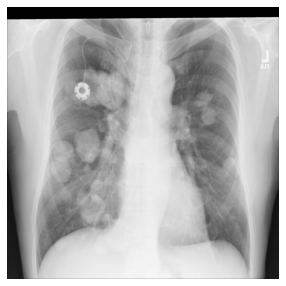

In [ ]:
ten_img.show()

Standarmäßig verwendet `TensorDicom` den Wert `gray` für den `cmap`-Parameter. Wir können die `cmap` jedoch auf den Wert `bone` ändern. Damit lassen sich die einzelnen Bereiche des Bildes besser abgrenzen.

In [ ]:
class TensorDicom(TensorImage): _show_args = {'cmap':'bone'}

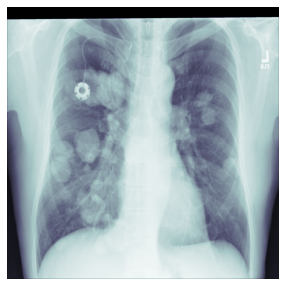

In [ ]:
ten_img2 = TensorDicom(xray_sample.pixel_array)
ten_img2.show()

Standardwerte für `matplotlib.rcParams` setzen:

In [ ]:
matplotlib.rcParams['image.cmap'] = 'bone'

### Die Klasse PILDicom

Die Klasse `PILDicom` erbt von `PILBase`.

Mithilfe von `PILBase` kann eine DICOM Datei direkt als `PILImage` geladen werden. Mithilfe der Methode `pydicom.dcmread` und dem `pixel_array` aus der DICOM Datei kann das Bild in voller Originalgröße geladen werden.

In [ ]:
type(PILDicom.create(items[patient]))

fastai.medical.imaging.PILDicom

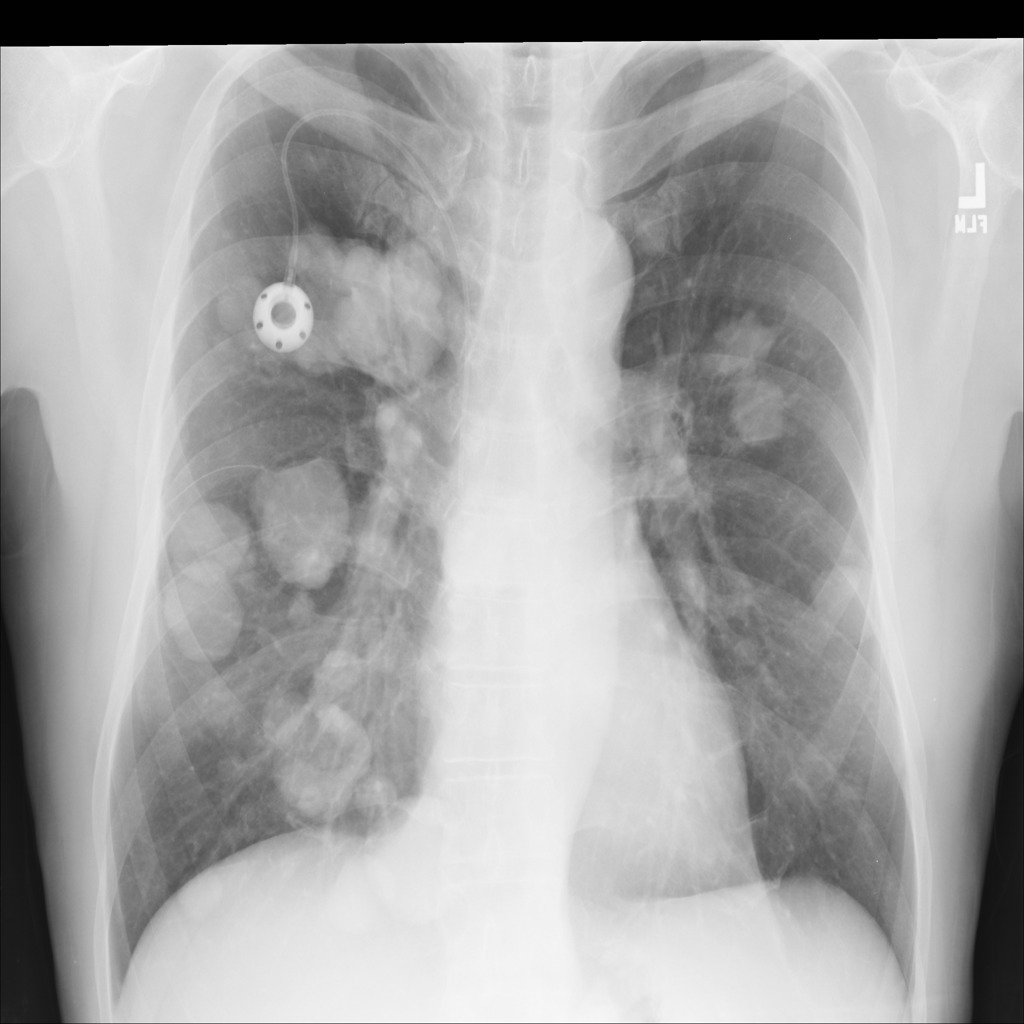

In [ ]:
PILDicom.create(items[patient])

### Pixel-Verteilung im DICOM Bild

Je näher die Verteilung der Pixel in den Bildern zu einer Normalverteilung ist, desto besser und schneller kann ein neuronales Netz trainiert werden.

In [ ]:
px = xray_sample.pixels.flatten()

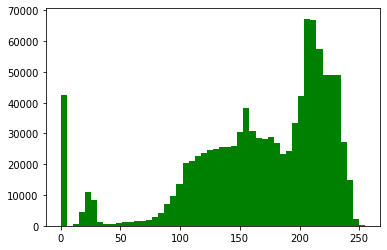

In [ ]:
plt.hist(px, bins=50, color='g');

Varianten der Pixelverteilung: Multimodal, Bimodal (mit genau 4 Spitzen). Um Bilder mit bi- oder multimodaler Pixelverteilung besser für das Training eines neuronalen Netzes vorzubereiten, teilen wir die Pixel in verschiedene Gruppen auf.

#### Aufteilung der Pixel in mehrere Gruppen

In [ ]:
# numpy Funktion zum Aufteilen der Pixel 
arry = array_freqhist_bins(xray_sample.pixel_array)
arry

array([  0,   1,  20,  25,  33,  77,  90,  96, 100, 103, 106, 109, 111, 114, 116, 118, 121, 123, 125, 127, 129, 131, 133, 135, 137, 139, 141, 144, 146, 148, 149, 151, 153, 154, 156, 158, 159, 161,
       163, 164, 166, 168, 170, 172, 174, 176, 177, 179, 181, 183, 185, 187, 190, 192, 194, 196, 197, 199, 200, 201, 202, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218,
       219, 220, 221, 222, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 237, 240, 243, 246], dtype=uint8)

In [ ]:
# Pendant für die Arbeit mit Tensoren
??pixels

## Analyse des Datensets

In [ ]:
def plot_comparison(df, feature, feature1):
    "Plot 3 comparisons from a dataframe"
    fig, (ax1, ax2) = plt.subplots(1,2, figsize = (16, 4))
    s1 = sns.countplot(df[feature], ax=ax1)
    s1.set_title(feature)
    s2 = sns.countplot(df[feature1], ax=ax2)
    s2.set_title(feature1)
    plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


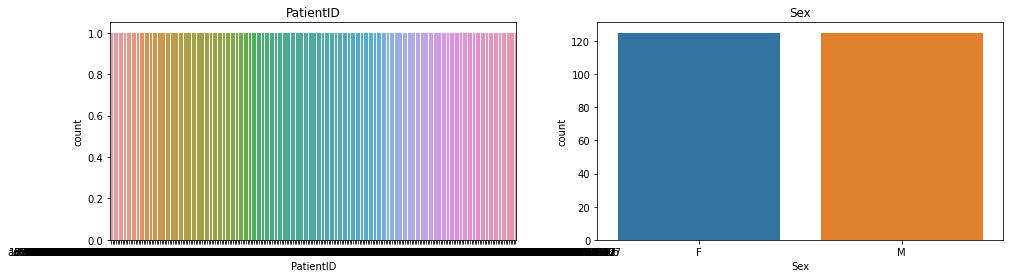

In [ ]:
plot_comparison(test_df, 'PatientID', 'Sex')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


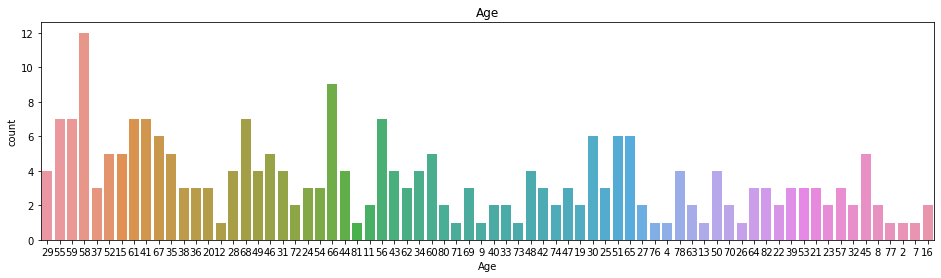

In [ ]:
def age_comparison(df, feature):
    "Plot hisogram of age range in dataset"
    fig, (ax1) = plt.subplots(1,1, figsize = (16, 4))
    s1 = sns.countplot(df[feature], ax=ax1)
    s1.set_title(feature)
    plt.show()
    
age_comparison(test_df, 'Age')

## Data Modelling

Bevor wir das Trainingsdatenset finalisieren können wir uns noch folgende Fragen stellen:

* Gibt es Patienten, die sowohl in den Trainings-, wie auch in den Validierungsdaten vorkommen?
* Anzahl der Sample: Wieviele positive und negative Beispiele sind in den Trainingsdaten enthalten? Wieviele in den Validierungsdaten?
* Data Augmentation: Welche Augmentation-Techniken können wir anwenden?

### Überlappung der Patienten in Trainings- und Validierungsdaten

In [ ]:
def DicomSplit(valid_pct=0.2, seed=None, **kwargs):
    "Splits `items` between train/val with `valid_pct`"
    "and checks if identical patient IDs exist in both the train and valid sets"
    def _inner(o, **kwargs):
        train_list=[]; valid_list=[]
        if seed is not None: torch.manual_seed(seed)
        rand_idx = L(int(i) for i in torch.randperm(len(o)))
        cut = int(valid_pct * len(o))
        trn = rand_idx[cut:]; trn_p = o[rand_idx[cut:]]
        val = rand_idx[:cut]; val_p = o[rand_idx[:cut]]
        
        for i, im in enumerate(trn_p):
            trn = im.dcmread()
            patient_ID = trn.PatientID
            train_list.append(patient_ID)
        for j, jm in enumerate(val_p):
            val = jm.dcmread()
            vpatient_ID = val.PatientID
            valid_list.append(vpatient_ID) 
        print(set(train_list) & set(valid_list))
        return rand_idx[cut:], rand_idx[:cut]
    return _inner

In [ ]:
# set_seed für reproduzierbare Ergebnisse
set_seed(7)

trn,val = DicomSplit(valid_pct=0.2)(items)
trn, val

set()


((#200) [33,65,231,167,74,127,184,89,122,79...],
 (#50) [115,233,139,163,161,177,57,21,34,99...])

### Verteilung der Klassen in Trainings- und Validierungsset

In [ ]:
def DataSplit(valid_pct=0.2, seed=None, **kwargs):
    "Check the number of each class in train and valid sets"
    def _inner(o, **kwargs):
        train_list=[]; valid_list=[]
        if seed is not None: torch.manual_seed(seed)
        rand_idx = L(int(i) for i in torch.randperm(len(o)))
        cut = int(valid_pct * len(o)) 
        trn_p = o[rand_idx[cut:]]
        val_p = o[rand_idx[:cut]]
        
        for p in enumerate(trn_p):            
            b = str(p).split('/')[-2]            
            train_list.append(b)
        for q in enumerate(val_p):
            e = str(q).split('/')[-2]
            valid_list.append(e)
        train_totals = {x:train_list.count(x) for x in train_list}
        valid_totals = {x:valid_list.count(x) for x in valid_list}
        print(f'Train totals: {train_totals}\nValid totals: {valid_totals}')
        return rand_idx[cut:], rand_idx[:cut]
    return _inner

In [ ]:
set_seed(7)

trn,val = DataSplit(valid_pct=0.2)(items)
trn, val

Train totals: {'No Pneumothorax': 141, 'Pneumothorax': 59}
Valid totals: {'No Pneumothorax': 34, 'Pneumothorax': 16}


((#200) [33,65,231,167,74,127,184,89,122,79...],
 (#50) [115,233,139,163,161,177,57,21,34,99...])

### Data Augmentation

Welche Art von Data-Augmentation können wir einsetzen?

## Labels für das Trainingsdatenset
Nachdem wir nun die DICOM Bilder laden können, benötigen wir auch noch die Labels für unsere Trainingsdaten.

In [ ]:
df = pd.read_csv(pneumothorax_source/f"labels.csv")
df.head()

,file,label
0,train/No Pneumothorax/000000.dcm,No Pneumothorax
1,train/Pneumothorax/000001.dcm,Pneumothorax
2,train/No Pneumothorax/000002.dcm,No Pneumothorax
3,train/Pneumothorax/000003.dcm,Pneumothorax
4,train/Pneumothorax/000004.dcm,Pneumothorax


In [ ]:
len(df)

250

## Aufbau des Trainingsdatesets mittels DataBlock

In [ ]:
pneumothorax = DataBlock(blocks=(ImageBlock(cls=PILDicom), CategoryBlock),
                   get_x=lambda x:pneumothorax_source/f"{x[0]}",
                   get_y=lambda x:x[1],
                   batch_tfms=[*aug_transforms(size=224),
                               Normalize.from_stats(*imagenet_stats)])

In [ ]:
dls = pneumothorax.dataloaders(df.values, num_workers=0)

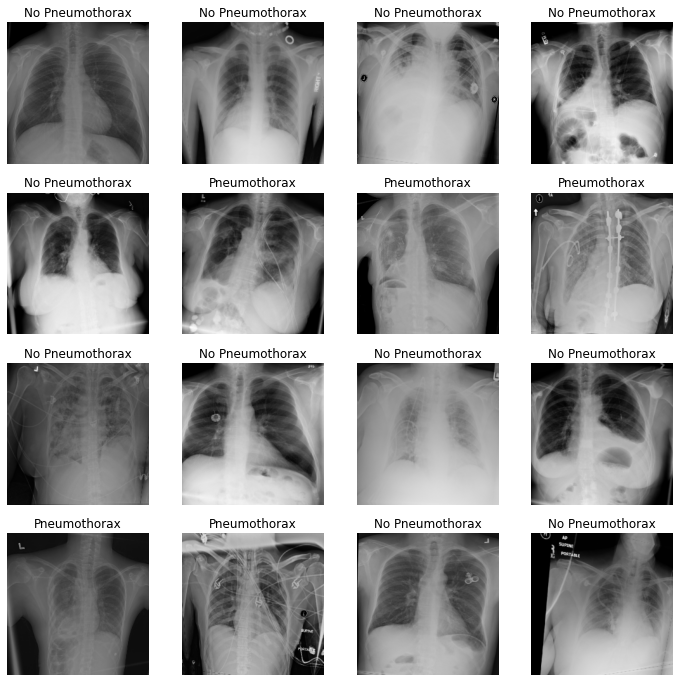

In [ ]:
dls = pneumothorax.dataloaders(df.values)
dls.show_batch(max_n=16)

## Training unseres DICOM Modells

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [ ]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

In [ ]:
learn.opt_func

<function fastai.optimizer.Adam>

SuggestedLRs(lr_min=0.006918309628963471, lr_steep=1.3182567499825382e-06)

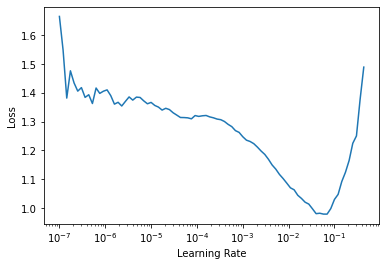

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(50)

epoch,train_loss,valid_loss,accuracy,time
0,1.214456,2.872562,0.300000,00:05
1,1.299926,2.277015,0.300000,00:05
2,1.297607,1.729902,0.360000,00:05
3,1.338171,1.296879,0.400000,00:05
4,1.298217,1.064159,0.460000,00:05
5,1.242067,0.861104,0.580000,00:05
6,1.216308,0.712879,0.640000,00:05
7,1.181886,0.613809,0.660000,00:05
8,1.117248,0.578818,0.700000,00:05
9,1.081789,0.533813,0.720000,00:05


## Prognosen

In [ ]:
learn.predict(pneumothorax_source/f"train/Pneumothorax/000004.dcm")

('Pneumothorax', tensor(1), tensor([0.0032, 0.9968]))

In [ ]:
tta = learn.tta(use_max=True)

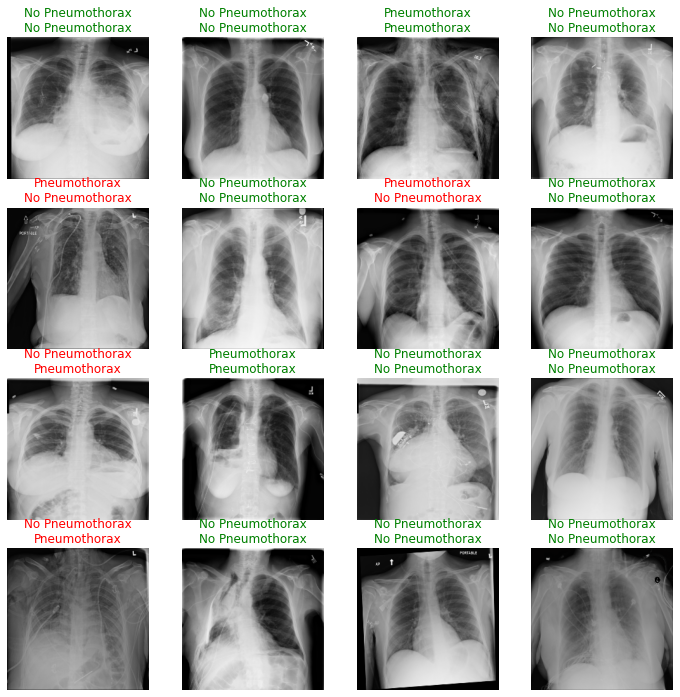

In [ ]:
learn.show_results(max_n=16)

In [ ]:
interp = Interpretation.from_learner(learn)

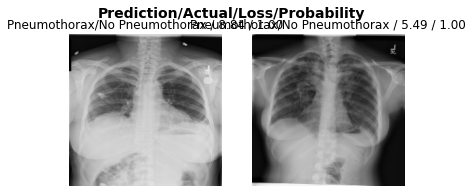

In [ ]:
interp.plot_top_losses(2)

## Ergebnis Interpretation - Confusion Matrix

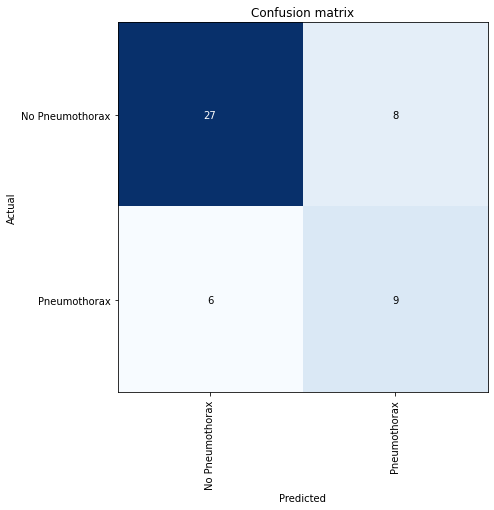

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(dls.valid_ds)==len(losses)==len(idxs)
interp.plot_confusion_matrix(figsize=(7,7))

In [ ]:
upp, low = interp.confusion_matrix()
tn, fp = upp[0], upp[1]
fn, tp = low[0], low[1]
print(tn, fp, fn, tp)

27 8 6 9


### Sensitivität
Sensitivität = RichtigPositiv / (RichtigPositiv + FalschNegativ)  
**Typ II Fehler**

In [ ]:
sensitivity = tp/(tp + fn)
sensitivity

0.6

### Spezifizität
Spezifizität = RichtigNegativ / (FalschPositiv + RichtigNegativ)  
**Typ I Fehler**

In [ ]:
specificity = tn/(fp + tn)
specificity

0.7714285714285715

### Positive Predictive Value (PPV)

In [ ]:
ppv = tp/(tp + fp)
ppv

0.5294117647058824

### Negative Predictive Value (NPV)

In [ ]:
npv = tn/(tn + fn)
npv

0.8181818181818182

### Accuracy
accurracy = sensitivity * prevalence + specificity * (1-prevalence)

**Prävalenz:** Anzahl an auftretenden Erkrankungen in einer bestimmten Grundpopulation über eine bestimmte Zeitspanne hinweg.

In unserem Beispiel ist die Prävalenz die Anzahl an erkrankten Personen im Validierungsdatenset verglichen der Anzahl an Erkrankten im Gesamtdatenset.

In [ ]:
val = dls.valid_ds.cat
val[0]

<bound method L.cat of TfmdLists: [['train/No Pneumothorax/000212.dcm' 'No Pneumothorax']
 ['train/No Pneumothorax/000103.dcm' 'No Pneumothorax']
 ['train/No Pneumothorax/000160.dcm' 'No Pneumothorax']
 ['train/No Pneumothorax/000085.dcm' 'No Pneumothorax']
 ['train/No Pneumothorax/000184.dcm' 'No Pneumothorax']
 ['train/Pneumothorax/000199.dcm' 'Pneumothorax']
 ['train/No Pneumothorax/000092.dcm' 'No Pneumothorax']
 ['train/No Pneumothorax/000080.dcm' 'No Pneumothorax']
 ['train/No Pneumothorax/000015.dcm' 'No Pneumothorax']
 ['train/No Pneumothorax/000169.dcm' 'No Pneumothorax']
 ['train/Pneumothorax/000233.dcm' 'Pneumothorax']
 ['train/No Pneumothorax/000033.dcm' 'No Pneumothorax']
 ['train/No Pneumothorax/000196.dcm' 'No Pneumothorax']
 ['train/No Pneumothorax/000115.dcm' 'No Pneumothorax']
 ['train/No Pneumothorax/000208.dcm' 'No Pneumothorax']
 ['train/No Pneumothorax/000204.dcm' 'No Pneumothorax']
 ['train/Pneumothorax/000111.dcm' 'Pneumothorax']
 ['train/No Pneumothorax/000195.

In [ ]:
prevalence = 15/50
prevalence

0.3

In [ ]:
accuracy = (sensitivity * prevalence) + (specificity * (1 - prevalence))
accuracy

0.72